In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.8.3
IPython 7.17.0

numpy 1.18.5
pandas 1.1.0
torch 1.6.0
transformers 3.0.2


In [2]:
# Import necessary libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from pprint import pprint

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
df = pd.read_csv("./data/eng-lem.csv", sep='\t', header=0)
df.head()

,word,lemma
0,10 Years of Time Team presented a round- up wh...,10 year of Time team present a round- up what ...
1,13 October 1962 marked the initial working ses...,13 October 1962 mark the initial working sessi...
2,"1945 Overhauled, Indianapolis joined Vice Admi...","1945 overhaul, Indianapolis join vice Admiral ..."
3,1965 was also the deadline for AAFSS selection...,"1965 be also the deadline for AAFSS selection,..."
4,"1969 to 1982 The British Telecom"" T symbol log...","1969 to 1982 the British Telecom"" T symbol log..."


In [4]:
df.shape

(9820, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9820 entries, 0 to 9819
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    9820 non-null   object
 1   lemma   9820 non-null   object
dtypes: object(2)
memory usage: 153.6+ KB


In [6]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [7]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [8]:
sample_txt = df['word'][3]
sample_txt2 = df['lemma'][3]
sample_txt, sample_txt2

('1965 was also the deadline for AAFSS selection, but program would become stuck in technical difficulties and political bickering.',
 '1965 be also the deadline for AAFSS selection, but program would become stick in technical difficulty and political bickering.')

In [9]:
tokens = tokenizer.tokenize(sample_txt2)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Sentence: 1965 was also the deadline for AAFSS selection, but program would become stuck in technical difficulties and political bickering.
   Tokens: ['1965', 'be', 'also', 'the', 'deadline', 'for', 'AA', '##FS', '##S', 'selection', ',', 'but', 'program', 'would', 'become', 'stick', 'in', 'technical', 'difficulty', 'and', 'political', 'bi', '##cker', '##ing', '.']
Token IDs: [2679, 1129, 1145, 1103, 17638, 1111, 10419, 17691, 1708, 4557, 117, 1133, 1788, 1156, 1561, 6166, 1107, 4301, 7262, 1105, 1741, 16516, 8638, 1158, 119]


In [10]:
encoding_original = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

encoding_original.keys()

dict_keys(['input_ids', 'attention_mask'])

In [11]:
encoding_target = tokenizer.encode_plus(
  sample_txt2,
  max_length=32,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

encoding_target.keys()

dict_keys(['input_ids', 'attention_mask'])

In [12]:
print(len(encoding_original['input_ids'][0]))
encoding_original['input_ids'][0]

32


tensor([  101,  2679,  1108,  1145,  1103, 17638,  1111, 10419, 17691,  1708,
         4557,   117,  1133,  1788,  1156,  1561,  5342,  1107,  4301,  7866,
         1105,  1741, 16516,  8638,  1158,   119,   102,     0,     0,     0,
            0,     0])

In [13]:
print(len(encoding_target['input_ids'][0]))
encoding_target['input_ids'][0]

32


tensor([  101,  2679,  1129,  1145,  1103, 17638,  1111, 10419, 17691,  1708,
         4557,   117,  1133,  1788,  1156,  1561,  6166,  1107,  4301,  7262,
         1105,  1741, 16516,  8638,  1158,   119,   102,     0,     0,     0,
            0,     0])

In [14]:
print(len(encoding_original['attention_mask'][0]))
encoding_original['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0]])

In [15]:
print(len(encoding_target['attention_mask'][0]))
encoding_target['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0]])

In [16]:
tokenizer.convert_ids_to_tokens(encoding_original['input_ids'][0]), tokenizer.convert_ids_to_tokens(encoding_target['input_ids'][0])

(['[CLS]',
  '1965',
  'was',
  'also',
  'the',
  'deadline',
  'for',
  'AA',
  '##FS',
  '##S',
  'selection',
  ',',
  'but',
  'program',
  'would',
  'become',
  'stuck',
  'in',
  'technical',
  'difficulties',
  'and',
  'political',
  'bi',
  '##cker',
  '##ing',
  '.',
  '[SEP]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]'],
 ['[CLS]',
  '1965',
  'be',
  'also',
  'the',
  'deadline',
  'for',
  'AA',
  '##FS',
  '##S',
  'selection',
  ',',
  'but',
  'program',
  'would',
  'become',
  'stick',
  'in',
  'technical',
  'difficulty',
  'and',
  'political',
  'bi',
  '##cker',
  '##ing',
  '.',
  '[SEP]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]'])

In [17]:
token_lens = []

for txt in df.word:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

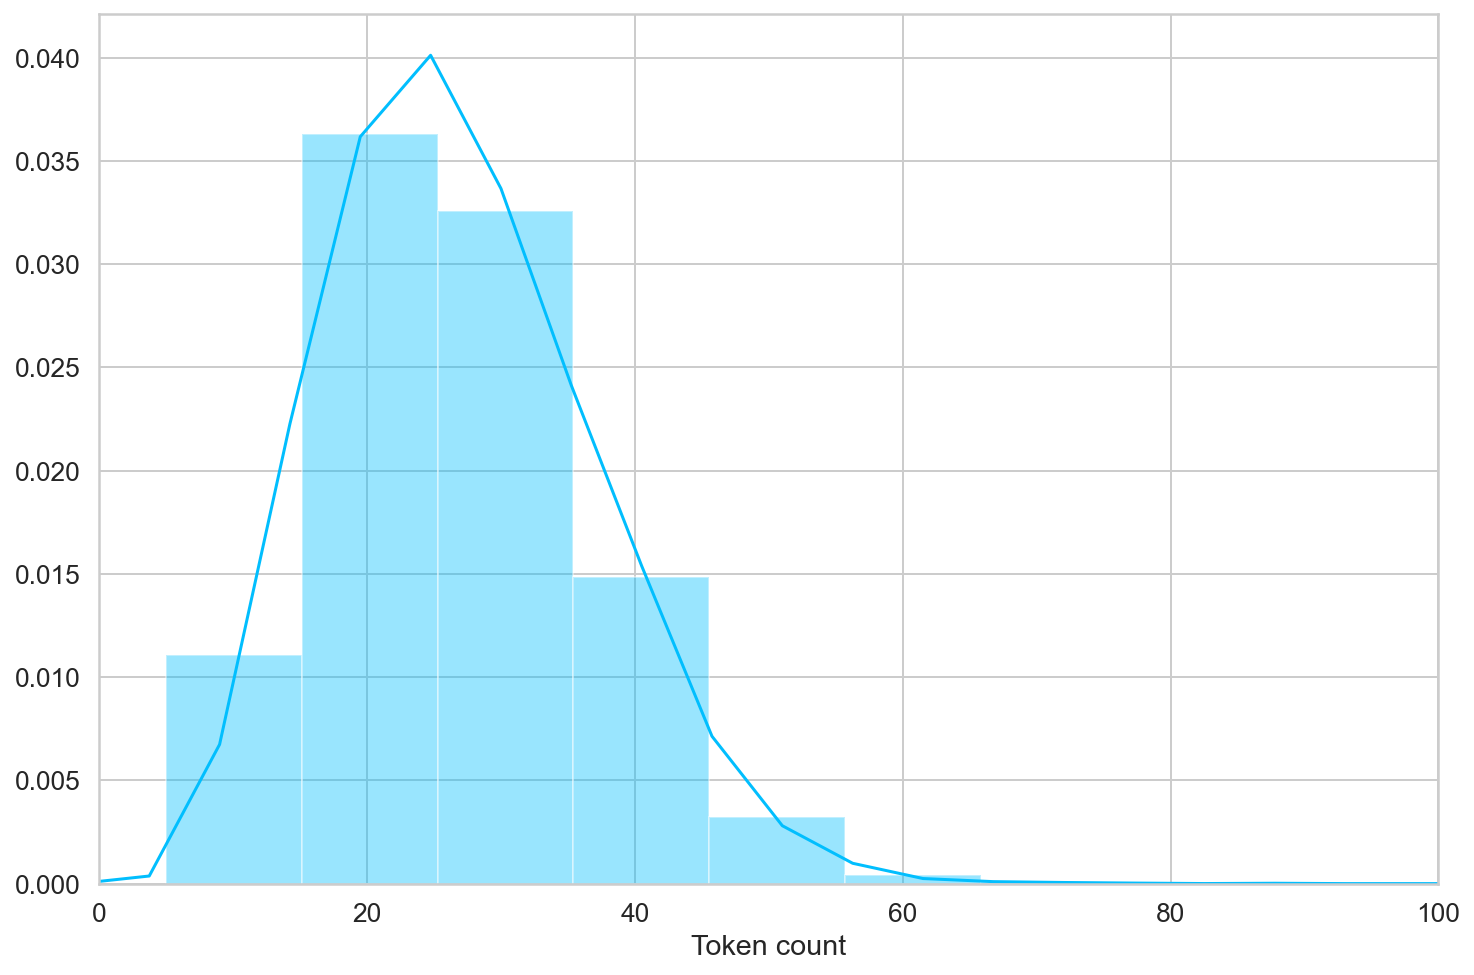

In [18]:
sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [19]:
MAX_LEN = 60

In [20]:
# Creating a torch dataset
class LemmatizationNLP(Dataset):
  # Constructor
  def __init__(self, originals, targets, tokenizer, max_len):
    self.originals = originals
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    # Denotes the total number of sentences
    return len(self.originals)
  
  def __getitem__(self, item):
    # Generates one sample of data
    original = str(self.originals[item])
    target = str(self.targets[item])

    encoding_original = self.tokenizer.encode_plus(
      original,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    encoding_target = self.tokenizer.encode_plus(
      target,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'original_text': original,
      'target_text': target,
      'input_ids': encoding_original['input_ids'].flatten(),
      'attention_mask': encoding_original['attention_mask'].flatten(),
      'target_ids': encoding_target['input_ids'].flatten(),
      'target_attention_mask': encoding_target['attention_mask'].flatten()
    }

In [21]:
df_train, df_test = train_test_split(
    df, 
    test_size=0.1, 
    random_state=RANDOM_SEED)

df_val, df_test = train_test_split(
    df_test, 
    test_size=0.5, 
    random_state=RANDOM_SEED)

In [22]:
df_train.shape, df_val.shape, df_test.shape

((8838, 2), (491, 2), (491, 2))

In [23]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  dataset = LemmatizationNLP(
    originals=df.word.to_numpy(),
    targets=df.lemma.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=0
  )

In [24]:
BATCH_SIZE = 16
MAX_EPOCH = 50

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [25]:
train_data_loader

In [26]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['original_text', 'target_text', 'input_ids', 'attention_mask', 'target_ids', 'target_attention_mask'])

In [28]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['target_ids'].shape)
print(data['target_attention_mask'].shape)

torch.Size([16, 60])
torch.Size([16, 60])
torch.Size([16, 60])
torch.Size([16, 60])
